
**[Coffee Bean Dataset](https://www.kaggle.com/datasets/gpiosenka/coffee-bean-dataset-resized-224-x-224?select=train)**

In [1]:
import numpy as np
import pandas as pd

import io
import os


from PIL import Image
from glob import glob
import itertools

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping , ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
train_dir = os.path.join( 'Coffee Bean Dataset/train')
test_dir = os.path.join('Coffee Bean Dataset/test')

In [3]:
df=pd.read_csv("Coffee Bean Dataset/Coffee Bean.csv")

In [4]:
df.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [5]:
df.labels.value_counts()

Dark      400
Green     400
Light     400
Medium    400
Name: labels, dtype: int64

In [6]:
df["data set"].value_counts()

train    1200
test      400
Name: data set, dtype: int64

**Data pre-processing and data augmentation**

In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.

In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

- configure random transformations and normalization operations to be done on your image data during training
- instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs, fit_generator, evaluate_generator and predict_generator.

In [7]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

These are just a few of the options available :-

- **rotation_range** is a value in degrees (0-180), a range within which to randomly rotate pictures
- **width_shift** and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
- **rescale** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- **shear_range** is for randomly applying shearing transformations
- **zoom_range** is for randomly zooming inside pictures
- **horizontal_flip** is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
- **fill_mode** is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.



In [8]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(test_dir,
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 1200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [9]:
folders = glob('Coffee Bean Dataset/train/*')
folders

['Coffee Bean Dataset/train\\Dark',
 'Coffee Bean Dataset/train\\Green',
 'Coffee Bean Dataset/train\\Light',
 'Coffee Bean Dataset/train\\Medium']

## Model creation 

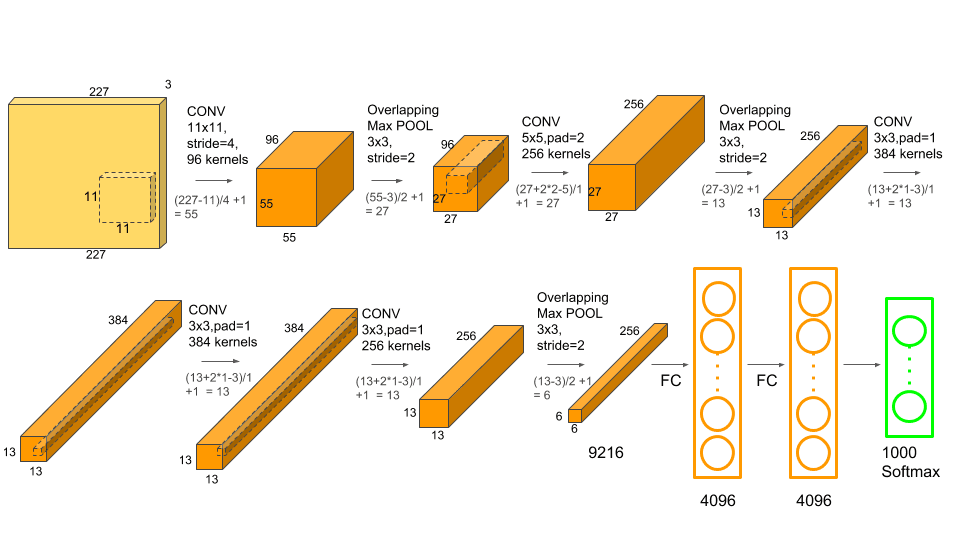
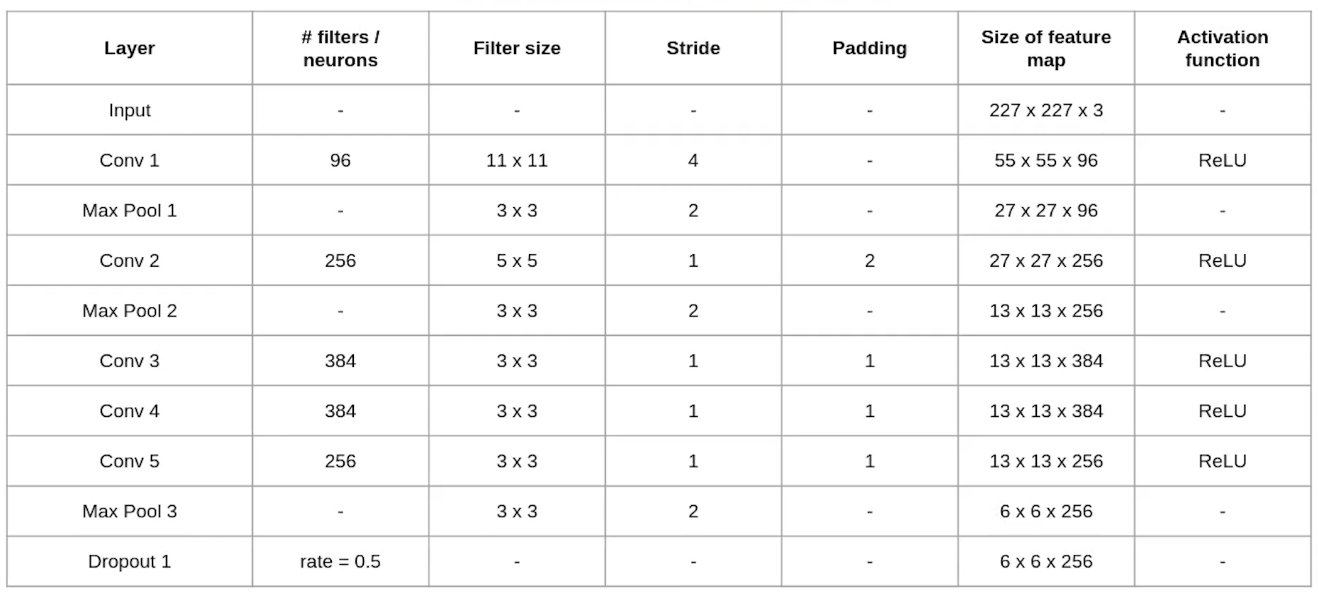

In [10]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), padding='valid', input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="valid"))

model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="valid"))

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="same"))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding="valid"))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))  

In [11]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.SGD(lr=0.001),
    metrics=['accuracy']    
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 26, 26, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                    

C:\Users\HP\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# fit the model
epochs = 50
history = model.fit(training_set, validation_data=test_set,epochs=epochs,
            steps_per_epoch=len(training_set),
            validation_steps=len(test_set), 
            verbose=1,)

Epoch 1/50
75/75 [==============================] - 60s 667ms/step - loss: 1.3863 - accuracy: 0.2433 - val_loss: 1.3840 - val_accuracy: 0.2500
Epoch 2/50
75/75 [==============================] - 44s 589ms/step - loss: 1.3836 - accuracy: 0.2675 - val_loss: 1.3824 - val_accuracy: 0.2500
Epoch 3/50
75/75 [==============================] - 17s 222ms/step - loss: 1.3832 - accuracy: 0.2667 - val_loss: 1.3805 - val_accuracy: 0.2500
Epoch 4/50
75/75 [==============================] - 16s 215ms/step - loss: 1.3819 - accuracy: 0.2550 - val_loss: 1.3791 - val_accuracy: 0.2500
Epoch 5/50
75/75 [==============================] - 16s 210ms/step - loss: 1.3816 - accuracy: 0.2617 - val_loss: 1.3777 - val_accuracy: 0.2925
Epoch 6/50
75/75 [==============================] - 16s 219ms/step - loss: 1.3783 - accuracy: 0.2708 - val_loss: 1.3760 - val_accuracy: 0.2625
Epoch 7/50
75/75 [==============================] - 16s 207ms/step - loss: 1.3783 - accuracy: 0.2700 - val_loss: 1.3740 - val_accuracy: 0.2825

In [17]:
scores = model.evaluate(test_set)

25/25 [==============================] - 1s 35ms/step - loss: 0.2751 - accuracy: 0.9175


In [18]:
print("test loss",scores[0])
print("test accuracy",scores[1])

test loss 0.2750852704048157
test accuracy 0.9175000190734863


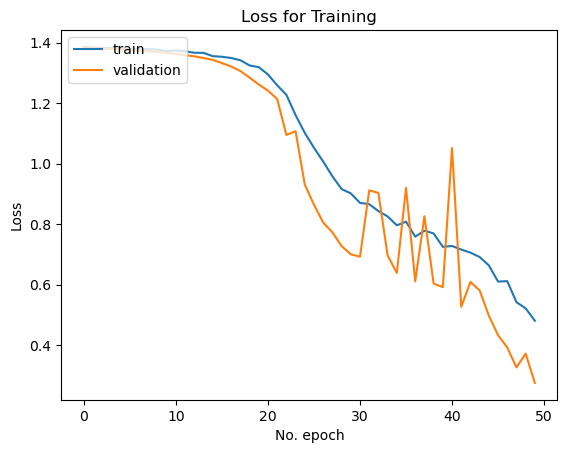

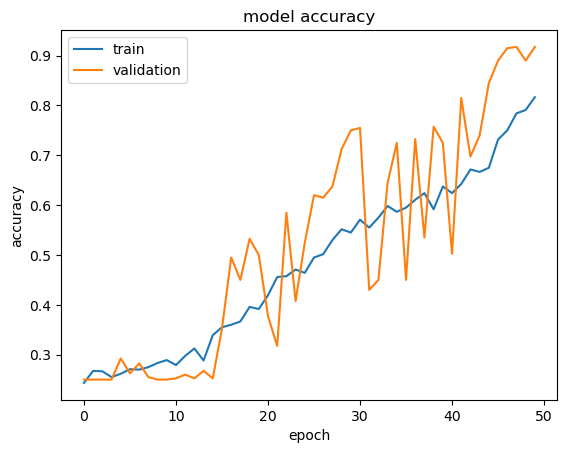

In [19]:
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Training')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(['train', 'validation'], loc="upper left")
plt.show()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()